In [ ]:
from _utils import *
from _polychrom import *
import openmm.testInstallation
openmm.testInstallation.main()

'''
 Polymer simulations
 This version implements simulations of Cohesin-mediated loop extrusion and heterotypic chromatin interactions.
 This script reads in 15 variable parameters from a text file.  The parameter text file is typically produced programatically, since parameters that specify all the CTCF sites, for example, are quite long arrays. 
'''
import sys

import os
import pickle 
import numpy as np
import numpy.matlib
import h5py
import ast
import pandas as pd
import math

from LEBondUpdater import bondUpdater

import polychrom
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.simulation import Simulation
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
import time

from tqdm.auto import tqdm
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))  # This prevents crash on GPU


2024-11-04 17:32:51.476650: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 17:32:51.520370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.



OpenMM Version: 8.1.1
Git Revision: Unknown

There are 4 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces
4 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.30444e-06
Reference vs. CUDA: 6.73389e-06
CPU vs. CUDA: 7.37001e-07
Reference vs. OpenCL: 6.73115e-06
CPU vs. OpenCL: 7.40271e-07
CUDA vs. OpenCL: 1.77396e-07

All differences are within tolerance.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load the dataset
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_maps = np.array([squareform(pdist(esc_polys[:80, :, i])) for i in range(esc_polys.shape[2])])
cnc_maps = np.array([squareform(pdist(cnc_polys[:80, :, i])) for i in range(cnc_polys.shape[2])])

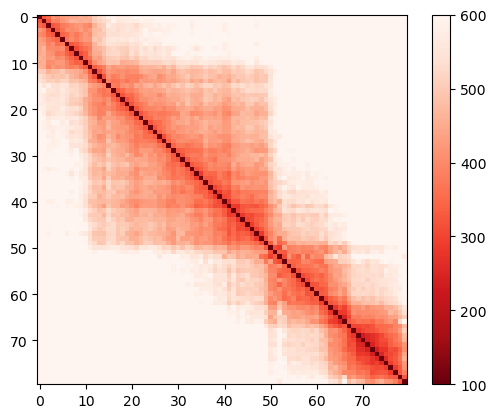

In [ ]:
plt.imshow(np.nanmedian(esc_maps, axis=0)[:80, :80], cmap='Reds_r',
           vmin=100, vmax=600)
plt.colorbar()

In [ ]:
monomers = 5000  # change this to multiple of ctcf sites 
replicates = 1
lef_lifetime = 20  # 40 gives better result than 10
lef_separation = 10
ctcf_sites = None 
ctcf_capture = 1
ctcf_release = 0.003
ctcf_dir = None 
monomer_types = None 
interaction_matrix = None 
trajectory_length = 1000 * 10  # More samples show better results 
density = 0.2
load_prob = 1/monomers 
gpu_id = "0"
repulsion = 6
lef_flag = True 

In [ ]:
ctcf_sites_one_iter = np.array([0, 11, 49, 62, 65, 80])
ctcf_capture_one_iter = np.array([1, 0.9, 0.9, 0.5, 0.9, 1])
ctcf_dir_one_iter = np.array([0, 0, 0, 0, 0, 0])

Max CTCF sites: 80.0
11 11 11
Max CTCF sites: 160.0
16 16 16
Max CTCF sites: 240.0
21 21 21
Max CTCF sites: 320.0
26 26 26
Max CTCF sites: 400.0
31 31 31
Max CTCF sites: 480.0
36 36 36
Max CTCF sites: 560.0
41 41 41
Max CTCF sites: 640.0
46 46 46
Max CTCF sites: 720.0
51 51 51
Max CTCF sites: 800.0
56 56 56
Max CTCF sites: 880.0
61 61 61
Max CTCF sites: 960.0
66 66 66
Max CTCF sites: 1040.0
71 71 71
Max CTCF sites: 1120.0
76 76 76
Max CTCF sites: 1200.0
81 81 81
Max CTCF sites: 1280.0
86 86 86
Max CTCF sites: 1360.0
91 91 91
Max CTCF sites: 1440.0
96 96 96
Max CTCF sites: 1520.0
101 101 101
Max CTCF sites: 1600.0
106 106 106
Max CTCF sites: 1680.0
111 111 111
Max CTCF sites: 1760.0
116 116 116
Max CTCF sites: 1840.0
121 121 121
Max CTCF sites: 1920.0
126 126 126
Max CTCF sites: 2000.0
131 131 131
Max CTCF sites: 2080.0
136 136 136
Max CTCF sites: 2160.0
141 141 141
Max CTCF sites: 2240.0
146 146 146
Max CTCF sites: 2320.0
151 151 151
Max CTCF sites: 2400.0
156 156 156
Max CTCF sites: 2

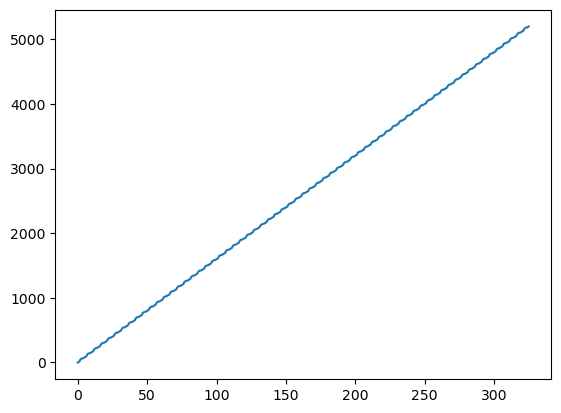

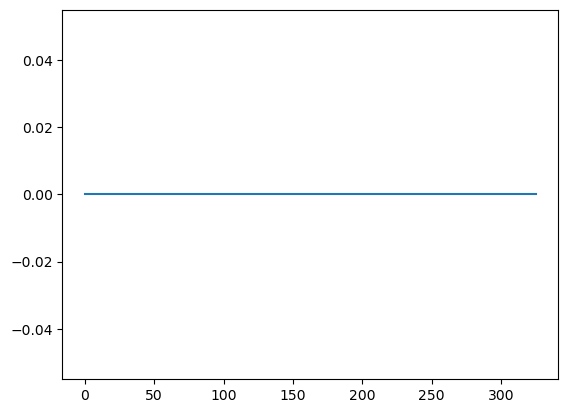

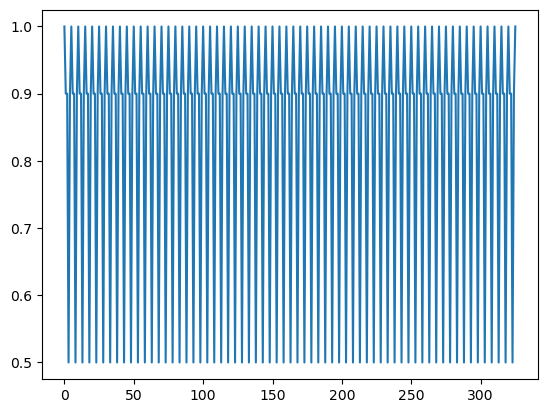

In [ ]:
monomers = int(ctcf_sites_one_iter.max())*65

ctcf_sites = np.append(np.zeros([0]), ctcf_sites_one_iter)
ctcf_capture = np.append(np.zeros([0]), ctcf_capture_one_iter)
ctcf_dir = np.append(np.zeros([0]), ctcf_dir_one_iter)

while np.max(ctcf_sites) < monomers:
    print('Max CTCF sites:', np.max(ctcf_sites))
    ctcf_sites_next = np.max(ctcf_sites) + ctcf_sites_one_iter 
    
    ctcf_sites = np.append(ctcf_sites, ctcf_sites_next[1:])
    ctcf_capture = np.append(ctcf_capture, ctcf_capture_one_iter[1:])
    ctcf_dir = np.append(ctcf_dir, ctcf_dir_one_iter[1:])
    
    print(len(ctcf_sites), len(ctcf_dir), len(ctcf_capture))
    
ctcf_sites = ctcf_sites.astype(int)[:monomers]
ctcf_capture = ctcf_capture[:monomers]
ctcf_dir = ctcf_dir[:monomers]

plt.plot(ctcf_sites)
plt.show()
plt.plot(ctcf_dir)
plt.show()

plt.plot(ctcf_capture)

In [ ]:
ctcf_release = np.ones_like(ctcf_sites) * ctcf_release
load_prob = np.ones(monomers) * load_prob

monomer_types = np.zeros(monomers, dtype=int)
interaction_matrix = np.array([[0, 0], [0, 0]])

In [ ]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_Interactive_Empirical/'

In [ ]:
# Change here
params = {
    'monomers': monomers,
    'replicates': replicates,
    'lef_lifetime': lef_lifetime,
    'lef_separation': lef_separation,
    'ctcf_capture': ctcf_capture,
    'ctcf_release': ctcf_release,
    'save_folder': save_folder,
    'ctcf_dir': ctcf_dir,
    'ctcf_sites': ctcf_sites,
    'monomer_types': monomer_types,
    'interaction_matrix': interaction_matrix,
    'trajectory_length': trajectory_length,
    'density': density,
    'load_prob': load_prob,
    'gpu_id': gpu_id,
    'repulsion': repulsion,
    'lef_flag': True
}

In [ ]:

# general parameters 
trajectoryLength = params['trajectory_length'] # time duration of simulation 
density = params['density'] #  0.2  # fraction of the volume of the sphere which is occupied by the polymer (or effective excluded volume, if using periodic boundary conditions)
  
   
#  ==========Extrusion sim parameters====================
# there is probably a more elegant way to read in text values than ast.literal_eval, but this works.  
GPU_ID = params['gpu_id'] # this should be a string -- which GPU to run on, eg "0", or "1" 
repulsionEnergy = params['repulsion'] # this is just a number
N1 = params['monomers'] # Number of monomers in the polymer/chromosome
M = params['replicates']  # Number of chromosomes in the simulation
num_chains = M  # same as above, multiple variable names were introduced.
N = N1 * M # total number of monomers in the full simulation 
LIFETIME = params['lef_lifetime'] #  extruder lifetime
SEPARATION = params['lef_separation'] # separation between extruders in monomer units (extruder density) 
ctcfSites = params['ctcf_sites'] # CTCF site locations, in monomer units
ctcfDir = params['ctcf_dir']  # CTCF site direction 
ctcfCapture = params['ctcf_capture'] # 0.9 80% capture probability per block, if capture < than this, capture  
ctcfRelease = params['ctcf_release'] # 0.003 % release probability per block, if capture < than this, release
interactionMatrix = params['interaction_matrix']  # interaction strength between different compartments 
saveFolder = params['save_folder']  # place to save the data
oneChainMonomerTypes =  params['monomer_types'] # compartment labels
lefFlag = params['lef_flag']
if len(oneChainMonomerTypes) != N1:
    oneChainMonomerTypes = np.zeros(N1).astype(int)
    
# Allow biased cohesin loading probabilities (e.g. as a function of chromatin state), if desired
loadProb = params['load_prob'] # discrete probability distribution that cohesin loads at site N
loadProb = numpy.matlib.repmat(loadProb,1,M)
loadProb = loadProb/np.sum(loadProb) 

if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)

lefPosFile = saveFolder + "LEFPos.h5"
if lefFlag:
    LEFNum = max(0,math.floor(N // SEPARATION )-1)
else:
    LEFNum = 0

# Optionally, tether the chromosome ends at random positions on the nulcear lamina
#   to use this, line 245 should be replaced with the commented line below it. 
#   select M random points on the edge of sphere
r = 1.05*(3 * N/ (4 * np.pi * density)) ** (1 / 3.0)
theta =np.random.rand(num_chains,1)*np.pi
psi = np.random.rand(num_chains,1)*2*np.pi
x= r*np.cos(psi)*np.sin(theta)
y= r*np.sin(psi)*np.sin(theta)
z= r*np.cos(theta)
end_tethers = np.concatenate((x,y,z),axis=1).tolist() 


# less common parameters
attraction_radius = 1.5
MDstepsPerCohesinStep = 800
smcBondWiggleDist = 0.2
smcBondDist = 0.5
saveEveryBlocks = 100   #
restartSimulationEveryBlocks = 100

# check that these loaded alright
print(f'LEF count: {LEFNum}')
print('interaction matrix:')
print(interactionMatrix)
print('monomer types:')
print(oneChainMonomerTypes)
print(saveFolder)
print('Starting simulation')


LEF count: 519
interaction matrix:
[[0 0]
 [0 0]]
monomer types:
[0 0 0 ... 0 0 0]
/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_Interactive_Empirical/
Starting simulation


In [ ]:


#==================================#
# Run 
#=================================#

#=========== 1D LE Simulation first ============#
import extrusion1Dv2 as ex1D # 1D classes 
ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

# should modify this to allow directionality
for i in range(M): # loop over chains (this variable needs a better name Max)
    for t in range(len(ctcfSites)):
        pos = i * N1 + ctcfSites[t] 
        if ctcfDir[t] == 0:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 1: # stop Cohesin moving toward the right  
            ctcfLeftCapture[pos] = 0  
            ctcfLeftRelease[pos] = 1  
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 2:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = 0
            ctcfRightRelease[pos] = 1
       
args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled 

occupied = np.zeros(N)
occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
occupied[-1] = 1 # [-1] is "python" for end
cohesins = []

print('starting simulation with N LEFs=')
print(LEFNum)
for i in tqdm(range(LEFNum)):
    ex1D.loadOneFromDist(cohesins,occupied, args,loadProb) # load the cohesins 
    
# if lefPosFile exists, delete it
if os.path.exists(lefPosFile):
    os.remove(lefPosFile)


with h5py.File(lefPosFile, mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 100    # saving in 100 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    print(len(bins))
    for st,end in tqdm(zip(bins[:-1], bins[1:])):
        cur = []
        for i in range(st, end):
            ex1D.translocate(cohesins, occupied, args,loadProb)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum
    


starting simulation with N LEFs=
519


  0%|          | 0/519 [00:00<?, ?it/s]

100


0it [00:00, ?it/s]

In [ ]:
#=========== Load LEF simulation ===========#
trajectory_file = h5py.File(lefPosFile, mode='r')
LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
LEFpositions = trajectory_file["positions"]  # array of LEF positions  
steps = MDstepsPerCohesinStep # MD steps per step of cohesin  (set to ~800 in real sims)
Nframes = LEFpositions.shape[0] # length of the saved trajectory (>25000 in real sims)
print(f'Length of the saved trajectory: {Nframes}')
block = 0  # starting block 

# test some properties 
# assertions for easy managing code below 
assert (Nframes % restartSimulationEveryBlocks) == 0 
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks
# concatinate monomers if needed
if len(oneChainMonomerTypes) != N:
    monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
else:
    monomerTypes = oneChainMonomerTypes
    
N_chain = len(oneChainMonomerTypes)  
N = len(monomerTypes)
print(f'N_chain: {N_chain}')  # ~8000 in a real sim
print(f'N: {N}')   # ~40000 in a real sim
N_traj = trajectory_file.attrs["N"]
print(f'N_traj: {N_traj}')
assert N == trajectory_file.attrs["N"]
print(f'Nframes: {Nframes}')
print(f'simInitsTotal: {simInitsTotal}')


Length of the saved trajectory: 10000
N_chain: 5200
N: 5200
N_traj: 5200
Nframes: 10000
simInitsTotal: 100


In [ ]:

#==============================================================#
#      RUN 3D simulation using 1D LEF constraints              #
#==============================================================#
milker = bondUpdater(LEFpositions)
data = grow_cubic(N,int((N/(density*1.2))**0.333))  # starting conformation
reporter = HDF5Reporter(folder=saveFolder, max_data_length=50, overwrite=True)
chains = [(N_chain*(k),N_chain*(k+1),0) for k in range(num_chains)]
positions_all_iterations = []

for iteration in tqdm(range(simInitsTotal)):
    position_curr_iteration = []
    a = Simulation(N=N, 
                   error_tol=0.01, 
                   collision_rate=0.01, 
                   integrator ="variableLangevin", 
                   GPU = "0",
                   platform="CUDA",
                   PBCbox=False, 
                   reporters=[reporter],
                   precision="mixed")  
    a.set_data(data)  # Start from previous positions
    position_curr_iteration.append(a.get_data())
    a.add_force(
        polychrom.forcekits.polymer_chains(
            a,
            chains=chains,
            nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
            nonbonded_force_kwargs={
                'repulsionEnergy': repulsionEnergy,  # base repulsion energy for all monomers (function default is 3.0)
                'attractionEnergy': 0,  # base attraction energy for all monomers (function default is 3.0)
                'attractionRadius': attraction_radius,
                'interactionMatrix': interactionMatrix,
                'monomerTypes': monomerTypes,
                'extraHardParticlesIdxs': []
            },
            bond_force_kwargs={
                'bondLength': 1,
                'bondWiggleDistance': 0.05
            },
            angle_force_kwargs={
                'k': 0.5 
            }
        )
    )
    a.add_force(polychrom.forces.spherical_confinement(a,density=density))
    # a.add_force(polychrom.forces.tether_particles(a,[0,N-1],positions=end_tethers,k=30))  # tether ends of polymer)
    
    # ------------ initializing milker; adding bonds ---------
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale
    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    
    milker.setParams(activeParams, inactiveParams)
    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)

    if iteration == 0:
        a.local_energy_minimization() 
        position_curr_iteration.append(a.get_data())
    else:
        a._apply_forces()
        position_curr_iteration.append(a.get_data())
    
    for i in range(restartSimulationEveryBlocks):        
        if i % saveEveryBlocks == (saveEveryBlocks - 1):  
            a.do_block(steps=steps)
            position_curr_iteration.append(a.get_data())
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
            position_curr_iteration.append(a.get_data())
        if i < restartSimulationEveryBlocks - 1: 
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds.
    
    # Change this line - move it inside the for loop to get a movie of the simulation
    data = a.get_data()  # save data and step, and delete the simulation
    
    del a
    
    reporter.blocks_only = False  # Write output hdf5-files only for blocks
    
    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    positions_all_iterations.append(position_curr_iteration)

reporter.dump_data()

  0%|          | 0/100 [00:00<?, ?it/s]

Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 29.268187
INFO:root:before minimization eK=1.5145875510669626, eP=29.268186603545683, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.953848
INFO:root:after minimization eK=1.5145875510669626, eP=0.8143148495092888, time=0.0 ps
INFO:root:block    0 pos[1]=[6.9 -3.6 14.7] dr=14.29 t=8848.6ps kin=1.87 pot=1.86 Rg=13.569 SPS=9169 dt=110.4fs dx=33.75pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.262077
INFO:root:block    0 pos[1]=[-4.2 -8.6 11.4] dr=11.56 t=8918.5ps kin=1.85 pot=1.82 Rg=13.625 SPS=9231 dt=111.0fs dx=33.77pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.828587
INFO:root:block    0 pos[1]=[0.9 -7.0 7.7] dr=10.37 t=8898.7ps kin=1.90 pot=1.85 Rg=13.562 SPS=9260 dt=110.4fs dx=33.98pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.953348
INFO:root:block    0 pos[1]=[6.7 -13.8 6.1] dr=12.08 t=8878.6ps kin=1.89 pot=1.83 Rg=13.700 SPS=9285 dt=113.7fs dx=34.86pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.016779
INFO:root:block    0 pos[1]=[-3.7 -13.7 0.1] dr=11.10 t=8877.5ps kin=1.89 pot=1.85 Rg=13.659 SPS=9243 dt=110.9fs dx=34.04pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.986521
INFO:root:block    0 pos[1]=[2.5 -8.1 5.0] dr=11.14 t=8858.7ps kin=1.90 pot=1.84 Rg=13.569 SPS=9270 dt=110.4fs dx=33.98pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.868373
INFO:root:block    0 pos[1]=[-6.8 -10.3 2.8] dr=9.96 t=8893.2ps kin=1.92 pot=1.83 Rg=13.630 SPS=9261 dt=110.9fs dx=34.33pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.097701
INFO:root:block    0 pos[1]=[0.1 -17.1 2.8] dr=10.81 t=8867.1ps kin=1.92 pot=1.86 Rg=13.682 SPS=9281 dt=111.1fs dx=34.39pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.078362
INFO:root:block    0 pos[1]=[9.9 -8.8 6.4] dr=11.27 t=8890.0ps kin=1.87 pot=1.87 Rg=13.691 SPS=9318 dt=111.2fs dx=34.00pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.122510
INFO:root:block    0 pos[1]=[-3.9 -9.0 0.8] dr=10.60 t=8907.9ps kin=1.91 pot=1.84 Rg=13.691 SPS=9323 dt=111.5fs dx=34.40pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.943515
INFO:root:block    0 pos[1]=[-9.6 -11.5 0.4] dr=13.34 t=8863.7ps kin=1.88 pot=1.80 Rg=13.691 SPS=9264 dt=110.5fs dx=33.85pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.898572
INFO:root:block    0 pos[1]=[1.1 -3.3 4.6] dr=11.69 t=8871.9ps kin=1.95 pot=1.88 Rg=13.631 SPS=9321 dt=111.3fs dx=34.71pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.948033
INFO:root:block    0 pos[1]=[-7.1 6.5 6.2] dr=11.28 t=8886.0ps kin=1.94 pot=1.83 Rg=13.552 SPS=9319 dt=111.9fs dx=34.77pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.089111
INFO:root:block    0 pos[1]=[-3.8 -10.7 -9.7] dr=11.29 t=8916.7ps kin=1.87 pot=1.81 Rg=13.516 SPS=9320 dt=111.0fs dx=33.89pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.917928
INFO:root:block    0 pos[1]=[-5.3 -15.6 1.2] dr=9.38 t=8892.4ps kin=1.86 pot=1.83 Rg=13.663 SPS=9274 dt=112.3fs dx=34.16pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.984090
INFO:root:block    0 pos[1]=[-2.3 -4.9 -4.6] dr=9.75 t=8859.7ps kin=1.89 pot=1.82 Rg=13.632 SPS=9275 dt=110.7fs dx=34.02pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.927434
INFO:root:block    0 pos[1]=[4.1 -10.8 10.4] dr=9.56 t=8862.7ps kin=1.90 pot=1.87 Rg=13.517 SPS=9235 dt=110.8fs dx=34.12pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.001436
INFO:root:block    0 pos[1]=[14.3 -2.4 -0.4] dr=12.70 t=8894.0ps kin=1.93 pot=1.85 Rg=13.689 SPS=9255 dt=111.4fs dx=34.57pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.019770
INFO:root:block    0 pos[1]=[8.3 4.8 -11.3] dr=10.73 t=8896.2ps kin=1.82 pot=1.82 Rg=13.646 SPS=9137 dt=111.0fs dx=33.45pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.925120
INFO:root:block    0 pos[1]=[7.1 5.1 1.7] dr=10.45 t=8889.2ps kin=1.86 pot=1.84 Rg=13.705 SPS=9272 dt=110.9fs dx=33.77pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.055009
INFO:root:block    0 pos[1]=[9.4 -4.2 2.9] dr=9.19 t=8873.9ps kin=1.87 pot=1.84 Rg=13.530 SPS=9329 dt=110.9fs dx=33.82pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.901331
INFO:root:block    0 pos[1]=[14.9 -1.3 1.2] dr=10.70 t=8911.3ps kin=1.87 pot=1.84 Rg=13.682 SPS=9221 dt=111.4fs dx=34.05pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.014887
INFO:root:block    0 pos[1]=[0.7 -0.4 -10.0] dr=9.69 t=8921.1ps kin=1.93 pot=1.86 Rg=13.594 SPS=9282 dt=110.8fs dx=34.41pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.048634
INFO:root:block    0 pos[1]=[-5.7 7.8 -4.5] dr=11.79 t=8872.1ps kin=1.86 pot=1.82 Rg=13.587 SPS=9346 dt=110.6fs dx=33.66pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.042359
INFO:root:block    0 pos[1]=[-3.9 -1.8 -13.4] dr=11.85 t=8913.1ps kin=1.86 pot=1.83 Rg=13.544 SPS=9316 dt=111.4fs dx=33.91pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.881719
INFO:root:block    0 pos[1]=[2.2 -11.6 -14.1] dr=10.46 t=8862.5ps kin=1.89 pot=1.82 Rg=13.536 SPS=9316 dt=110.3fs dx=33.87pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.997867
INFO:root:block    0 pos[1]=[-3.4 -2.4 -11.1] dr=10.63 t=8902.5ps kin=1.89 pot=1.82 Rg=13.676 SPS=9304 dt=111.4fs dx=34.25pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.132244
INFO:root:block    0 pos[1]=[-2.7 -10.5 -11.3] dr=11.45 t=8898.1ps kin=1.95 pot=1.83 Rg=13.424 SPS=9272 dt=110.8fs dx=34.59pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.975327
INFO:root:block    0 pos[1]=[1.0 -13.1 -7.1] dr=10.23 t=8878.5ps kin=1.85 pot=1.82 Rg=13.697 SPS=9335 dt=110.8fs dx=33.63pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.965396
INFO:root:block    0 pos[1]=[-6.4 -12.1 -9.5] dr=10.75 t=8904.9ps kin=1.91 pot=1.88 Rg=13.736 SPS=9265 dt=111.0fs dx=34.27pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.033346
INFO:root:block    0 pos[1]=[7.3 1.0 -16.7] dr=11.89 t=8897.9ps kin=1.99 pot=1.85 Rg=13.547 SPS=9285 dt=110.7fs dx=34.90pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.008696
INFO:root:block    0 pos[1]=[3.2 2.6 3.0] dr=10.54 t=8869.7ps kin=1.90 pot=1.83 Rg=13.599 SPS=9312 dt=110.8fs dx=34.12pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.843554
INFO:root:block    0 pos[1]=[5.4 1.1 9.0] dr=12.60 t=8911.8ps kin=1.92 pot=1.85 Rg=13.538 SPS=9314 dt=111.1fs dx=34.36pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.096815
INFO:root:block    0 pos[1]=[10.2 2.1 -0.9] dr=9.64 t=8866.3ps kin=1.93 pot=1.87 Rg=13.628 SPS=9311 dt=110.6fs dx=34.33pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.164517
INFO:root:block    0 pos[1]=[9.0 10.1 5.4] dr=10.50 t=8880.9ps kin=1.97 pot=1.89 Rg=13.603 SPS=9330 dt=109.9fs dx=34.45pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.156624
INFO:root:block    0 pos[1]=[0.0 5.1 15.0] dr=11.60 t=8890.0ps kin=1.84 pot=1.81 Rg=13.561 SPS=9274 dt=110.6fs dx=33.55pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.124429
INFO:root:block    0 pos[1]=[1.1 -0.7 -0.1] dr=11.83 t=8897.4ps kin=1.88 pot=1.83 Rg=13.618 SPS=9297 dt=111.0fs dx=34.01pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.119659
INFO:root:block    0 pos[1]=[4.1 9.4 10.9] dr=10.23 t=8875.5ps kin=1.88 pot=1.84 Rg=13.641 SPS=9277 dt=111.2fs dx=34.06pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.049717
INFO:root:block    0 pos[1]=[3.4 14.6 6.8] dr=11.33 t=8887.2ps kin=1.86 pot=1.81 Rg=13.613 SPS=9346 dt=111.5fs dx=33.99pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.907376
INFO:root:block    0 pos[1]=[-1.9 -2.2 -13.4] dr=11.68 t=8840.7ps kin=1.89 pot=1.83 Rg=13.674 SPS=9266 dt=110.2fs dx=33.85pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.986100
INFO:root:block    0 pos[1]=[2.2 3.1 -15.2] dr=11.96 t=8880.3ps kin=1.89 pot=1.81 Rg=13.507 SPS=9276 dt=110.9fs dx=34.04pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.966246
INFO:root:block    0 pos[1]=[5.9 1.9 -8.7] dr=10.66 t=8916.4ps kin=1.92 pot=1.84 Rg=13.735 SPS=9284 dt=110.6fs dx=34.23pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.141810
INFO:root:block    0 pos[1]=[-0.1 -13.8 -4.8] dr=10.20 t=8881.0ps kin=1.86 pot=1.82 Rg=13.442 SPS=8981 dt=110.6fs dx=33.69pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.830942
INFO:root:block    0 pos[1]=[4.6 -12.5 -8.7] dr=9.86 t=8828.8ps kin=1.89 pot=1.82 Rg=13.815 SPS=9254 dt=110.4fs dx=33.87pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.988028
INFO:root:block    0 pos[1]=[2.3 -12.9 -8.2] dr=10.48 t=8906.9ps kin=1.90 pot=1.83 Rg=13.627 SPS=9283 dt=111.2fs dx=34.25pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.054101
INFO:root:block    0 pos[1]=[4.4 6.7 -14.4] dr=11.77 t=8894.0ps kin=1.90 pot=1.82 Rg=13.563 SPS=9263 dt=110.4fs dx=33.98pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.946199
INFO:root:block    0 pos[1]=[2.5 10.4 -9.3] dr=12.31 t=8893.1ps kin=1.85 pot=1.85 Rg=13.601 SPS=9275 dt=110.8fs dx=33.68pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.920377
INFO:root:block    0 pos[1]=[-5.8 5.2 -8.1] dr=10.18 t=8885.3ps kin=1.89 pot=1.85 Rg=13.602 SPS=9249 dt=111.0fs dx=34.09pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.100909
INFO:root:block    0 pos[1]=[11.2 9.1 -2.5] dr=10.33 t=8855.8ps kin=1.83 pot=1.83 Rg=13.865 SPS=9255 dt=110.6fs dx=33.41pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.970931
INFO:root:block    0 pos[1]=[8.5 3.0 -13.6] dr=9.82 t=8894.8ps kin=1.97 pot=1.85 Rg=13.737 SPS=9306 dt=111.0fs dx=34.83pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.122090
INFO:root:block    0 pos[1]=[4.6 12.7 -2.9] dr=11.75 t=8881.2ps kin=1.81 pot=1.79 Rg=13.703 SPS=9153 dt=113.3fs dx=34.07pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.747603
INFO:root:block    0 pos[1]=[10.4 6.9 -4.8] dr=8.95 t=8887.6ps kin=1.95 pot=1.82 Rg=13.665 SPS=9267 dt=111.2fs dx=34.64pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.184535
INFO:root:block    0 pos[1]=[14.4 2.7 0.7] dr=9.85 t=8871.9ps kin=1.86 pot=1.79 Rg=13.709 SPS=9291 dt=111.7fs dx=34.00pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.025425
INFO:root:block    0 pos[1]=[3.1 4.4 -12.0] dr=9.78 t=8871.4ps kin=1.93 pot=1.85 Rg=13.516 SPS=9288 dt=110.9fs dx=34.39pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.160725
INFO:root:block    0 pos[1]=[5.6 1.1 -3.0] dr=10.81 t=8884.7ps kin=1.87 pot=1.80 Rg=13.477 SPS=9276 dt=111.3fs dx=33.97pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.887171
INFO:root:block    0 pos[1]=[12.5 2.3 5.0] dr=11.72 t=8884.1ps kin=1.88 pot=1.83 Rg=13.745 SPS=9242 dt=110.6fs dx=33.89pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.094897
INFO:root:block    0 pos[1]=[7.9 3.1 -3.0] dr=10.21 t=8852.9ps kin=1.91 pot=1.87 Rg=13.614 SPS=9299 dt=110.6fs dx=34.16pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.119492
INFO:root:block    0 pos[1]=[8.6 -10.1 6.2] dr=10.09 t=8879.9ps kin=1.86 pot=1.83 Rg=13.621 SPS=9285 dt=110.4fs dx=33.62pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.767489
INFO:root:block    0 pos[1]=[2.8 -9.4 7.9] dr=11.93 t=8919.1ps kin=1.91 pot=1.86 Rg=13.592 SPS=9240 dt=111.3fs dx=34.33pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.055396
INFO:root:block    0 pos[1]=[-9.2 -3.2 4.3] dr=9.13 t=8841.7ps kin=1.92 pot=1.84 Rg=13.540 SPS=9250 dt=110.5fs dx=34.19pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.982582
INFO:root:block    0 pos[1]=[-5.7 2.8 -2.4] dr=10.06 t=8870.4ps kin=1.88 pot=1.81 Rg=13.608 SPS=9318 dt=110.8fs dx=33.93pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.838291
INFO:root:block    0 pos[1]=[5.6 -3.7 4.6] dr=11.44 t=8892.1ps kin=1.90 pot=1.82 Rg=13.619 SPS=9260 dt=110.8fs dx=34.12pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.015804
INFO:root:block    0 pos[1]=[13.0 -1.8 4.0] dr=10.81 t=8896.7ps kin=1.92 pot=1.83 Rg=13.747 SPS=9235 dt=111.0fs dx=34.35pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.985067
INFO:root:block    0 pos[1]=[14.1 -3.2 5.9] dr=10.37 t=8876.5ps kin=1.94 pot=1.85 Rg=13.437 SPS=9291 dt=110.5fs dx=34.41pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.016740
INFO:root:block    0 pos[1]=[12.7 -10.4 -7.7] dr=10.50 t=8896.1ps kin=1.96 pot=1.89 Rg=13.638 SPS=9235 dt=111.2fs dx=34.73pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.123015
INFO:root:block    0 pos[1]=[10.2 -10.4 -8.2] dr=11.51 t=8857.4ps kin=1.87 pot=1.87 Rg=13.657 SPS=9268 dt=110.3fs dx=33.71pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.015803
INFO:root:block    0 pos[1]=[3.5 -5.4 -5.8] dr=11.03 t=8896.4ps kin=1.87 pot=1.85 Rg=13.631 SPS=9225 dt=111.5fs dx=34.02pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.967491
INFO:root:block    0 pos[1]=[3.9 -11.6 -9.0] dr=10.81 t=8883.4ps kin=1.90 pot=1.85 Rg=13.596 SPS=9287 dt=110.8fs dx=34.08pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.075501
INFO:root:block    0 pos[1]=[6.0 3.4 1.9] dr=10.06 t=8861.1ps kin=1.87 pot=1.84 Rg=13.583 SPS=9262 dt=110.3fs dx=33.65pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.044399
INFO:root:block    0 pos[1]=[6.0 -3.9 7.0] dr=10.33 t=8903.2ps kin=1.91 pot=1.82 Rg=13.612 SPS=9255 dt=111.2fs dx=34.31pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.916451
INFO:root:block    0 pos[1]=[6.9 3.1 8.9] dr=10.38 t=8900.1ps kin=1.83 pot=1.82 Rg=13.591 SPS=9237 dt=110.9fs dx=33.53pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.888350
INFO:root:block    0 pos[1]=[14.2 -1.8 12.2] dr=11.85 t=8887.8ps kin=1.88 pot=1.84 Rg=13.544 SPS=9258 dt=110.9fs dx=33.94pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.860615
INFO:root:block    0 pos[1]=[8.4 -5.8 9.8] dr=10.48 t=8883.3ps kin=1.92 pot=1.85 Rg=13.637 SPS=9235 dt=110.8fs dx=34.29pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.122714
INFO:root:block    0 pos[1]=[1.5 -3.3 -0.8] dr=11.23 t=8915.0ps kin=1.91 pot=1.84 Rg=13.558 SPS=9301 dt=111.3fs dx=34.31pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.042865
INFO:root:block    0 pos[1]=[9.2 0.9 -4.8] dr=12.42 t=8884.9ps kin=1.92 pot=1.86 Rg=13.572 SPS=9313 dt=111.0fs dx=34.34pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.909808
INFO:root:block    0 pos[1]=[13.9 5.9 -0.6] dr=11.00 t=8878.9ps kin=1.96 pot=1.88 Rg=13.566 SPS=9337 dt=110.4fs dx=34.54pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.061300
INFO:root:block    0 pos[1]=[16.9 6.1 2.0] dr=11.42 t=8889.6ps kin=1.89 pot=1.86 Rg=13.639 SPS=9224 dt=111.5fs dx=34.27pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.311735
INFO:root:block    0 pos[1]=[13.1 9.8 4.4] dr=10.32 t=8883.4ps kin=1.93 pot=1.84 Rg=13.615 SPS=9223 dt=111.4fs dx=34.57pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.013179
INFO:root:block    0 pos[1]=[2.3 -0.4 -12.3] dr=12.63 t=8881.2ps kin=1.87 pot=1.81 Rg=13.451 SPS=9304 dt=111.2fs dx=33.97pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.660689
INFO:root:block    0 pos[1]=[2.6 3.1 -15.3] dr=10.88 t=8881.1ps kin=1.90 pot=1.84 Rg=13.596 SPS=9115 dt=110.8fs dx=34.13pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.946223
INFO:root:block    0 pos[1]=[3.2 -13.9 -7.0] dr=10.91 t=8900.8ps kin=1.86 pot=1.81 Rg=13.574 SPS=9274 dt=111.1fs dx=33.83pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.096907
INFO:root:block    0 pos[1]=[2.5 -7.9 -7.9] dr=9.72 t=8870.7ps kin=1.88 pot=1.85 Rg=13.643 SPS=9314 dt=110.2fs dx=33.73pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.973690
INFO:root:block    0 pos[1]=[9.7 -8.2 -9.6] dr=11.08 t=8873.2ps kin=1.91 pot=1.84 Rg=13.439 SPS=9333 dt=112.3fs dx=34.68pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.894022
INFO:root:block    0 pos[1]=[3.8 -0.1 -4.0] dr=10.12 t=8875.4ps kin=1.89 pot=1.83 Rg=13.652 SPS=9225 dt=111.1fs dx=34.12pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.908897
INFO:root:block    0 pos[1]=[-1.5 2.1 -17.4] dr=11.44 t=8882.9ps kin=1.91 pot=1.83 Rg=13.552 SPS=9315 dt=110.8fs dx=34.25pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.016141
INFO:root:block    0 pos[1]=[-10.7 -8.7 -10.8] dr=10.71 t=8861.5ps kin=1.91 pot=1.84 Rg=13.722 SPS=9314 dt=109.7fs dx=33.82pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.994880
INFO:root:block    0 pos[1]=[-11.2 -6.5 -10.4] dr=10.54 t=8878.8ps kin=1.87 pot=1.82 Rg=13.548 SPS=9273 dt=110.8fs dx=33.86pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.869050
INFO:root:block    0 pos[1]=[-1.3 -16.3 -5.1] dr=10.48 t=8868.2ps kin=1.88 pot=1.82 Rg=13.613 SPS=9287 dt=110.6fs dx=33.83pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.918504
INFO:root:block    0 pos[1]=[2.2 -15.2 -6.4] dr=11.15 t=8876.3ps kin=1.93 pot=1.87 Rg=13.503 SPS=9208 dt=110.9fs dx=34.39pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.079924
INFO:root:block    0 pos[1]=[10.4 -9.3 7.5] dr=11.68 t=8865.3ps kin=1.89 pot=1.85 Rg=13.569 SPS=9289 dt=111.2fs dx=34.18pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.145756
INFO:root:block    0 pos[1]=[8.8 -9.9 -3.8] dr=11.74 t=8858.1ps kin=1.90 pot=1.83 Rg=13.566 SPS=9322 dt=110.5fs dx=34.05pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.925833
INFO:root:block    0 pos[1]=[9.8 -6.1 -3.8] dr=10.14 t=8889.3ps kin=1.85 pot=1.82 Rg=13.699 SPS=9186 dt=111.1fs dx=33.73pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.940426
INFO:root:block    0 pos[1]=[15.0 2.8 -3.8] dr=9.95 t=8885.0ps kin=1.89 pot=1.81 Rg=13.630 SPS=9308 dt=110.7fs dx=33.95pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.851781
INFO:root:block    0 pos[1]=[3.0 -1.5 -17.7] dr=11.63 t=8890.2ps kin=1.87 pot=1.83 Rg=13.545 SPS=9245 dt=111.4fs dx=34.04pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.938839
INFO:root:block    0 pos[1]=[2.7 -1.1 -9.8] dr=11.95 t=8905.2ps kin=1.87 pot=1.87 Rg=13.623 SPS=9319 dt=111.0fs dx=33.95pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.908748
INFO:root:block    0 pos[1]=[10.9 9.4 -7.8] dr=10.95 t=8868.2ps kin=1.92 pot=1.84 Rg=13.597 SPS=9258 dt=111.2fs dx=34.44pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.096645
INFO:root:block    0 pos[1]=[-3.5 -3.2 -8.1] dr=12.46 t=8901.7ps kin=1.91 pot=1.84 Rg=13.585 SPS=9249 dt=112.2fs dx=34.66pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 3.163176
INFO:root:block    0 pos[1]=[-4.7 4.9 -7.5] dr=12.27 t=8900.7ps kin=1.88 pot=1.81 Rg=13.418 SPS=9263 dt=111.1fs dx=34.00pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.886555
INFO:root:block    0 pos[1]=[-6.4 6.8 -9.6] dr=10.61 t=8897.5ps kin=1.94 pot=1.86 Rg=13.581 SPS=9228 dt=110.0fs dx=34.23pm 


Exclude neighbouring chain particles from heteropolymer_SSW
Number of exceptions: 5199


INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force heteropolymer_SSW 2
INFO:root:adding force spherical_confinement 3
INFO:root:Particles loaded. Potential energy is 2.982062
INFO:root:block    0 pos[1]=[-12.0 4.4 -3.2] dr=11.37 t=8896.6ps kin=1.85 pot=1.80 Rg=13.567 SPS=9272 dt=111.0fs dx=33.70pm 


In [ ]:
positions_all_iterations = np.array(positions_all_iterations)
sample_polys = []
sample_dmaps = []
for sample in positions_all_iterations:
    sample_polys.append(sample[-1, :, :])
    sample_dmaps.append(squareform(pdist(sample[-1, :, :])))

In [ ]:
# Export positions_all_iterations
with open(save_folder + 'positions_all_iterations.pkl', 'wb') as f:
    pickle.dump(positions_all_iterations, f)


OpenMM Version: 8.1.1
Git Revision: Unknown



In [ ]:
# Save the map every 80 monomers 
sample_dmaps = np.array(sample_dmaps)
sample_polys = np.array(sample_polys)

In [ ]:
sample_dmaps.shape

(100, 5200, 5200)

In [ ]:
sample_dmaps_all = []
sample_polys_all = []

num_iters = sample_dmaps.shape[1] // 80
num_reps = sample_dmaps.shape[0]
for i in range(num_reps):
    curr_polys = sample_polys[i, :, :]
    curr_dmaps = sample_dmaps[i, :, :]
    for j in range(num_iters):
        sample_dmaps_all.append(curr_dmaps[j*80:(j+1)*80, j*80:(j+1)*80])
        sample_polys_all.append(curr_polys[j*80:(j+1)*80, :])

In [ ]:
sample_median_maps = np.median(sample_dmaps_all, axis=0)

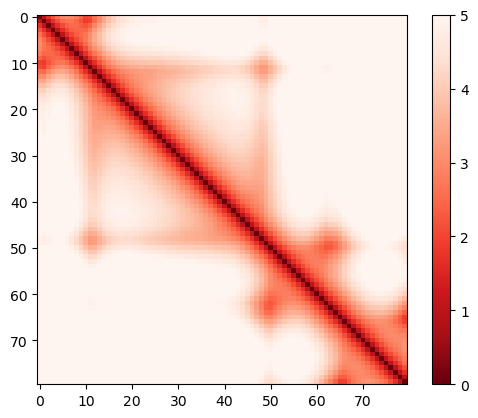

In [ ]:
plt.imshow(sample_median_maps[:80, :80], cmap='Reds_r', vmin=0, vmax=5)
plt.colorbar()

In [ ]:
contact_threshold = np.mean(np.diag(sample_median_maps, 1))
contact_threshold

1.0034418376472847

In [ ]:
sample_cmaps_all = np.array(sample_dmaps_all) < 3

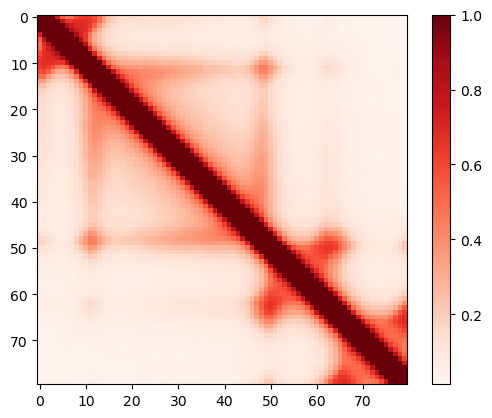

In [ ]:
plt.imshow(np.mean(sample_cmaps_all, axis=0), cmap='Reds')
plt.colorbar()

In [ ]:
positions_all_iterations.shape

(100, 102, 5200, 3)

In [ ]:
curr_iter = positions_all_iterations[0]

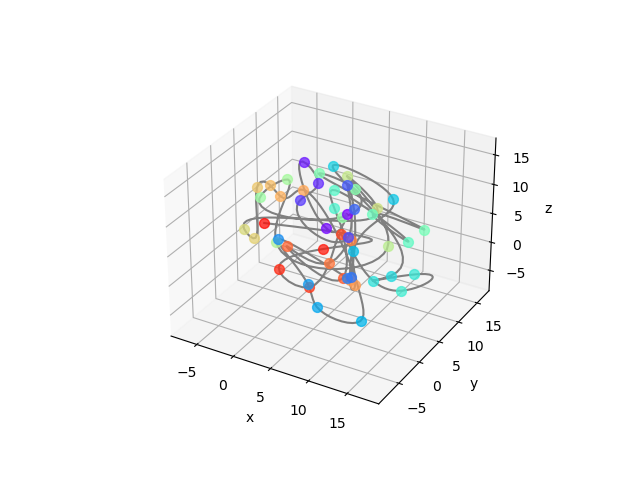

In [ ]:
visualize_polymer(curr_iter[2, ::100, :])
plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


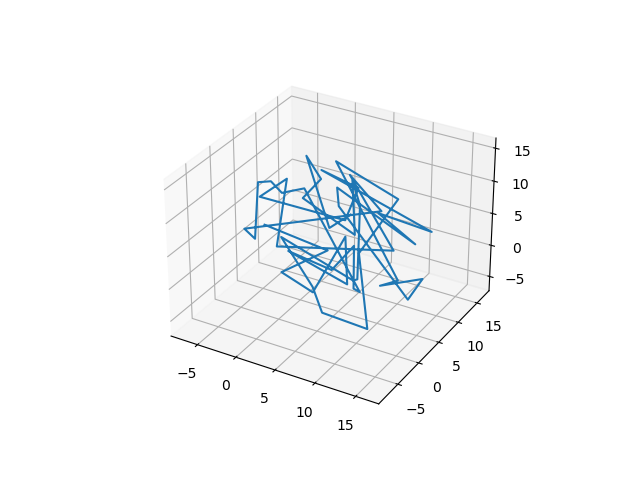

In [ ]:
from matplotlib.animation import FuncAnimation
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize the scatter plot
scat = ax.plot([], [], [])

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.plot(curr_iter[frame, ::100, 0], curr_iter[frame, ::100, 1], curr_iter[frame, ::100, 2])
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=50, interval=50, blit=False)
HTML(ani.to_jshtml())
plt.show()

In [ ]:
from IPython.display import HTML
%matplotlib widget

In [ ]:
plt.close()

/tmp/ipykernel_123463/530900788.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


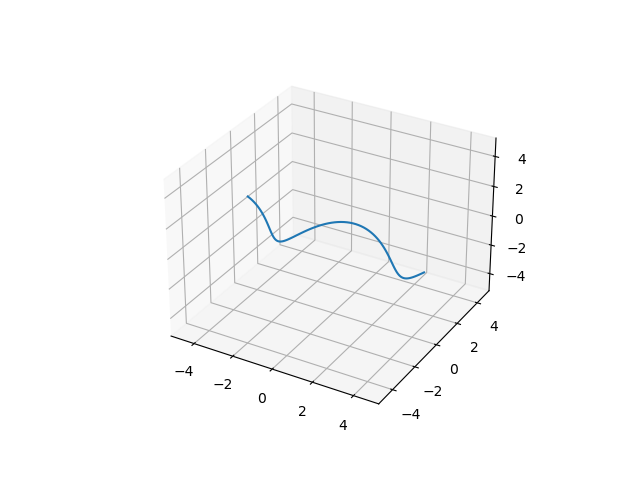

/tmp/ipykernel_123463/3402912174.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [ ]:
# Set up the figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the plot limits
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

# Initial data
x = np.linspace(-5, 5, 100)
y = np.sin(x)
z = np.cos(x)
line, = ax.plot(x, y, z, label='3D curve')

# Define the update function for the animation
def update(frame):
    y = np.sin(x + frame / 10.0)
    z = np.cos(x + frame / 10.0)
    line.set_data(x, y)
    line.set_3d_properties(z)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(100), interval=100)

HTML(ani.to_jshtml())
